In [12]:
# import the necessary packages
from os import listdir
from os.path import isfile, join
from skimage.metrics import normalized_root_mse as compare_nrmse
from skimage.metrics import structural_similarity as ssim
from sys import argv, exit, stderr
from os.path import dirname
import cv2 as cv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

In [134]:
def center_shift(file_root, img1_seq, img2_seq):
    img1 = cv.imread(f'./jpgs/{file_root}/frame{img1_seq:06d}.jpg', cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(f'./jpgs/{file_root}/frame{img2_seq:06d}.jpg', cv.IMREAD_GRAYSCALE)
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    MIN_MATCH_COUNT = 10

    good = []
    for m,n in matches:
        if m.distance < 0.25*n.distance:
            good.append(m)

#     print(f'{img1_seq}: Good matches (match[0].distance < 0.25*match[1].distance): {len(good)}')
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img1.shape
        pts = np.float32([ [w/2.0,h/2.0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
#         print(f'{np.linalg.norm(dst-pts):0.2f}: {pts[0][0]} -> {dst[0][0]}')
#         return (pts, dst)
        return (np.linalg.norm(dst-pts), len(good), np.count_nonzero(mask))
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None


In [135]:
def do_homography_on_folder(file_root):
    onlyfiles = [f for f in listdir(f'./jpgs/{file_root}/') if isfile(join(f'./jpgs/{file_root}/', f))]

    shifts = []
    good_matches = []
    inliers = []
    for i in range(len(onlyfiles)-1):
        res = center_shift(file_root, i, i+1)
        shifts.append(res[0])
        good_matches.append(res[1])
        inliers.append(res[2])
        
    df = pd.DataFrame({'shift': shifts})
    df.plot()
    plt.show()
    df = pd.DataFrame({'matches': good_matches, 'inliers': inliers })
    df.plot()
    plt.show()
    return df

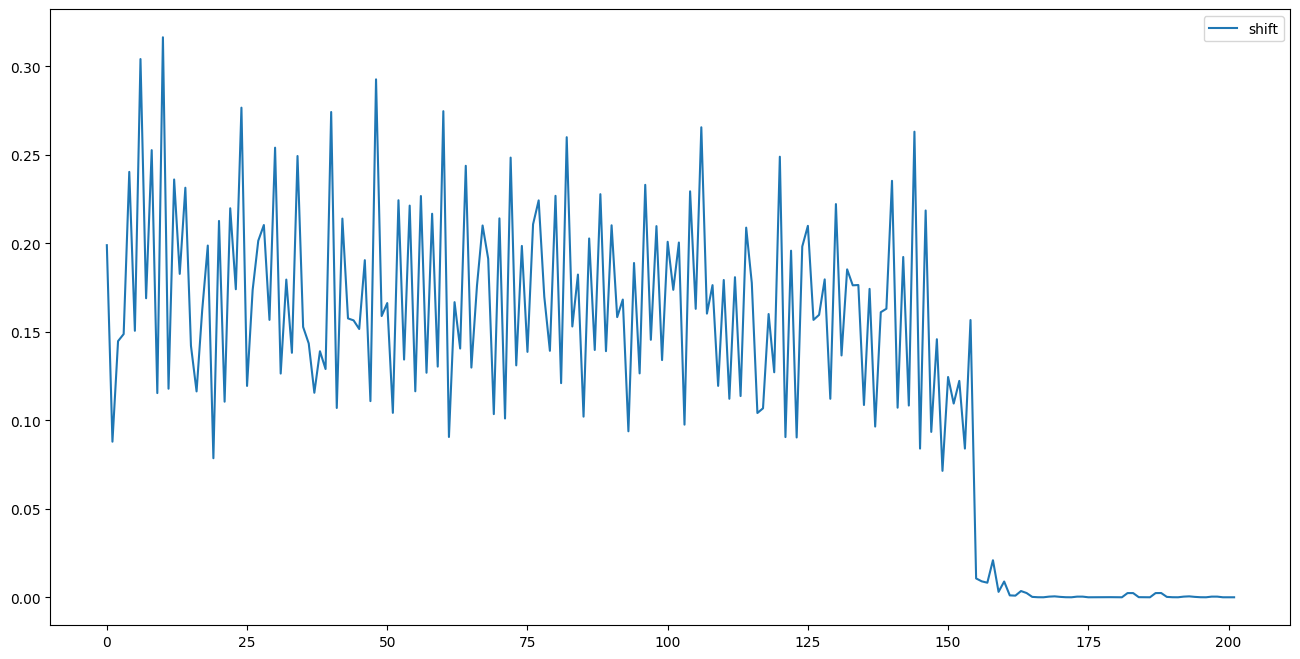

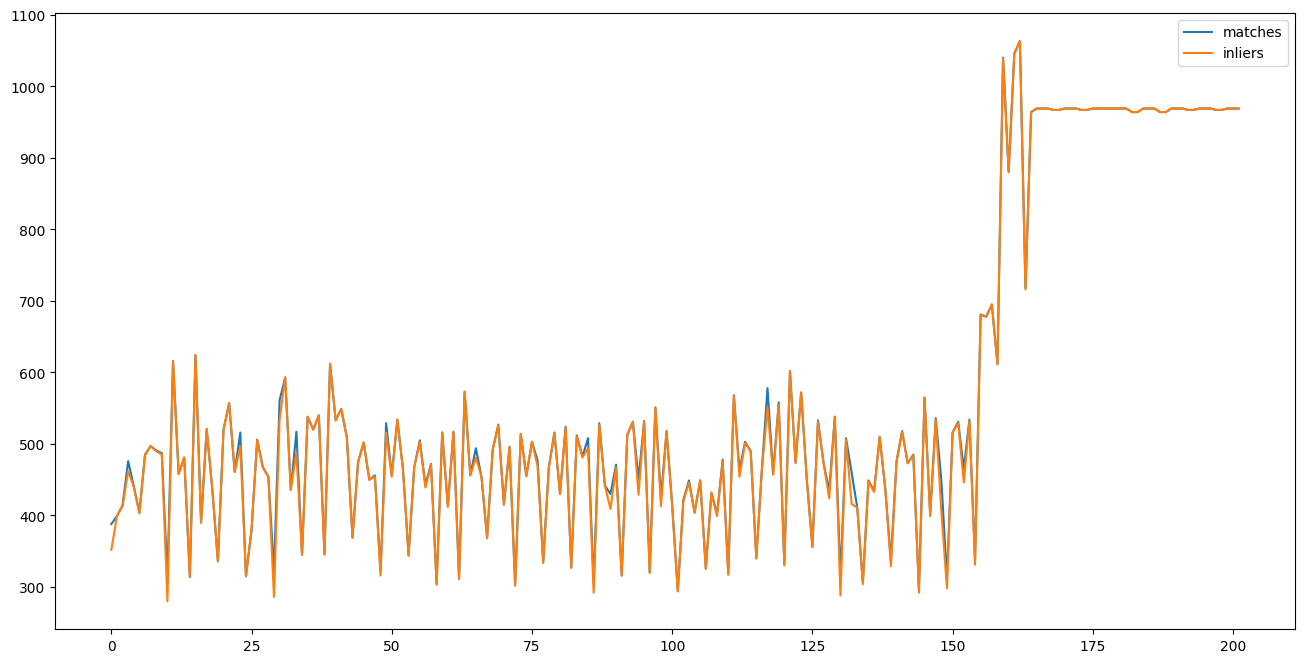

In [138]:
# Part breaking off starting #145. Then minor spaghetti run-offs

df = do_homography_on_folder('FAILED_Fab365_Foldable_Marvin_0.1mm_PLA_MK3SMMU2S_12h47m_20220906132658')

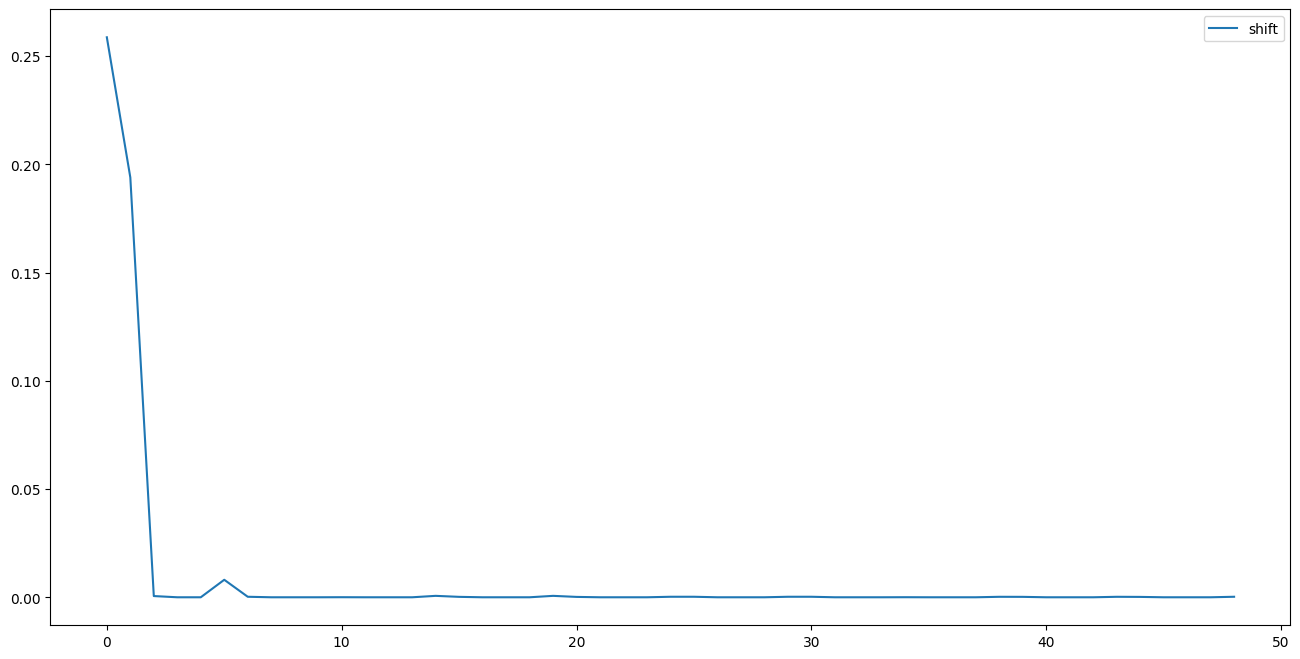

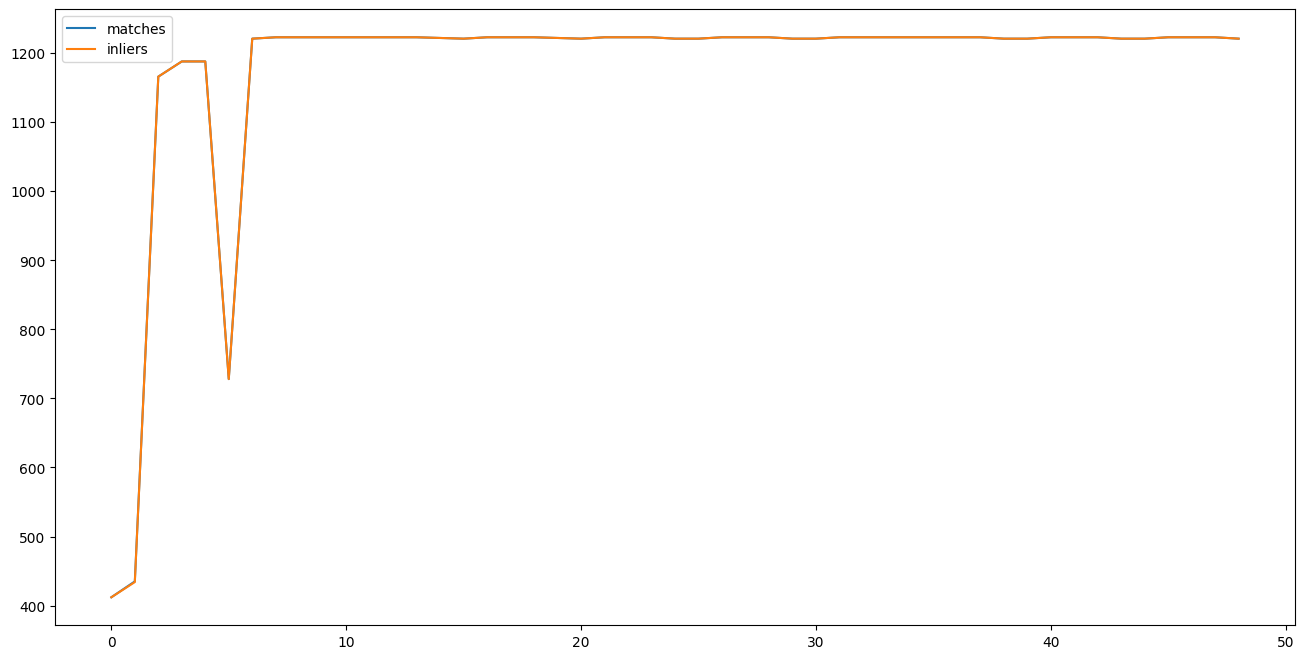

In [139]:
# Seeminly big change on frame #001 but ssim is 0.95. Frame #005 was 0.98 probably due to a tiny bed shift

df = do_homography_on_folder('FAILED_FR_Mount_0.2mm_PLA_MK3SMMU2S_6h28m_20220827030911')

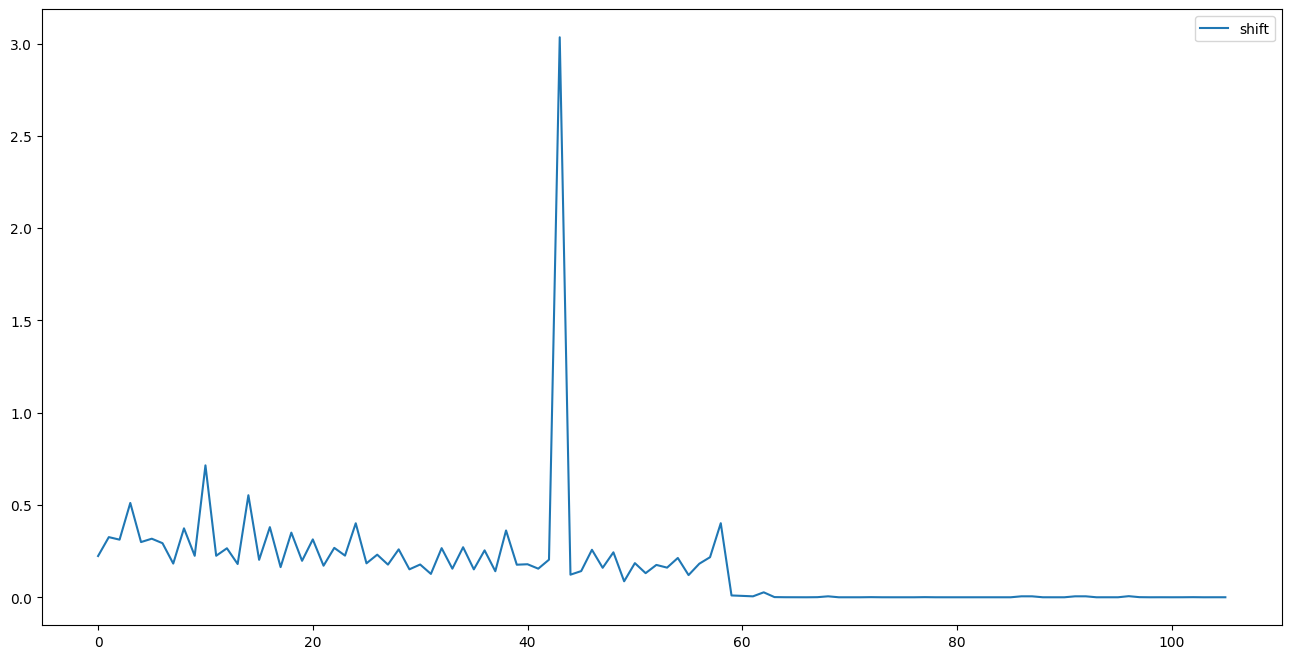

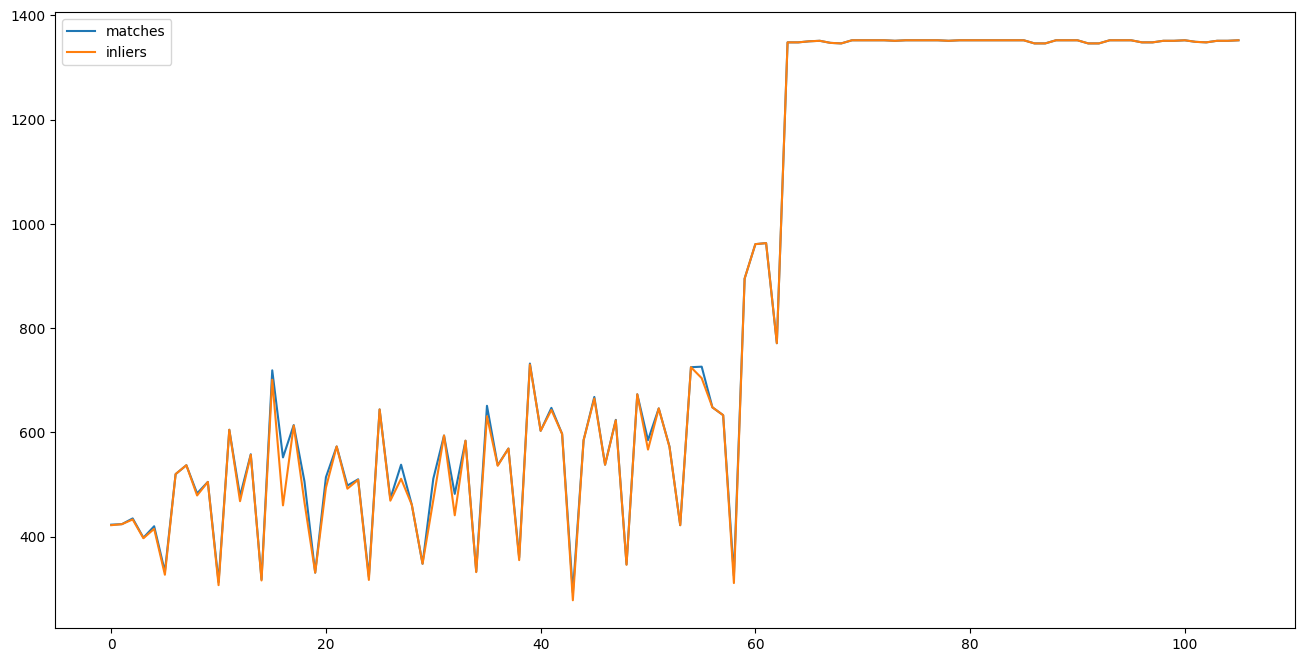

In [140]:
# Frame #043 due to bed shifting. #57 is when object becomes detached. 

df = do_homography_on_folder('FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220502124240')

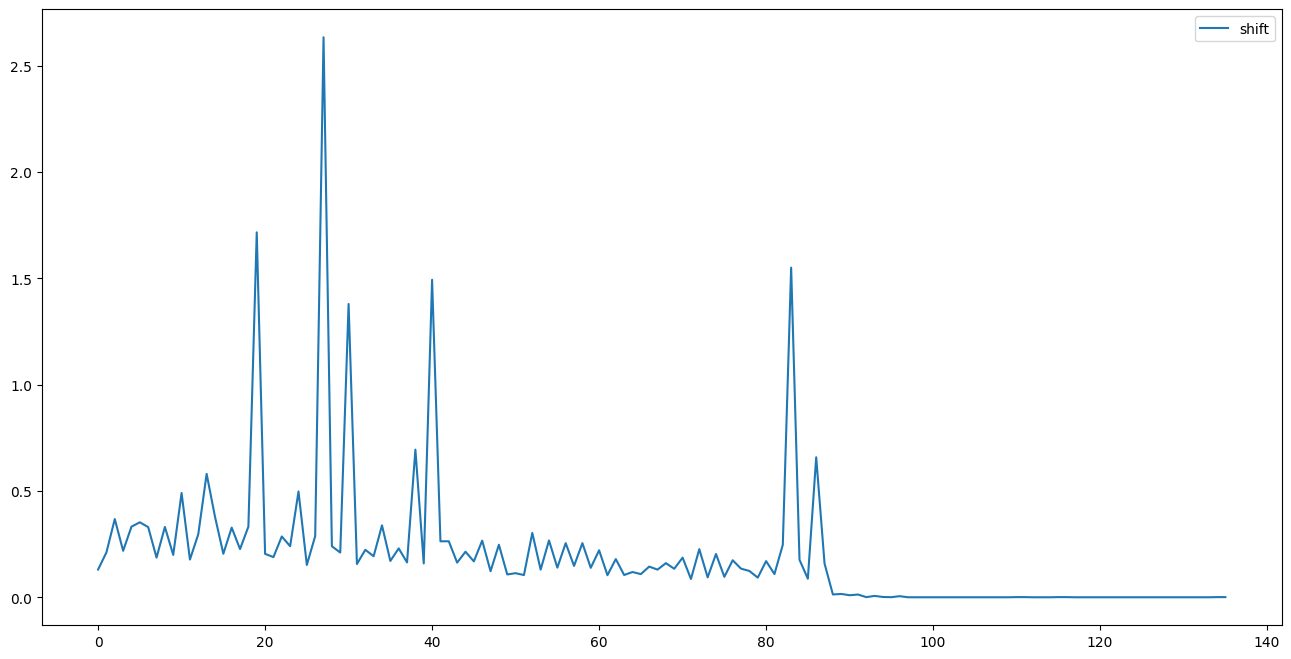

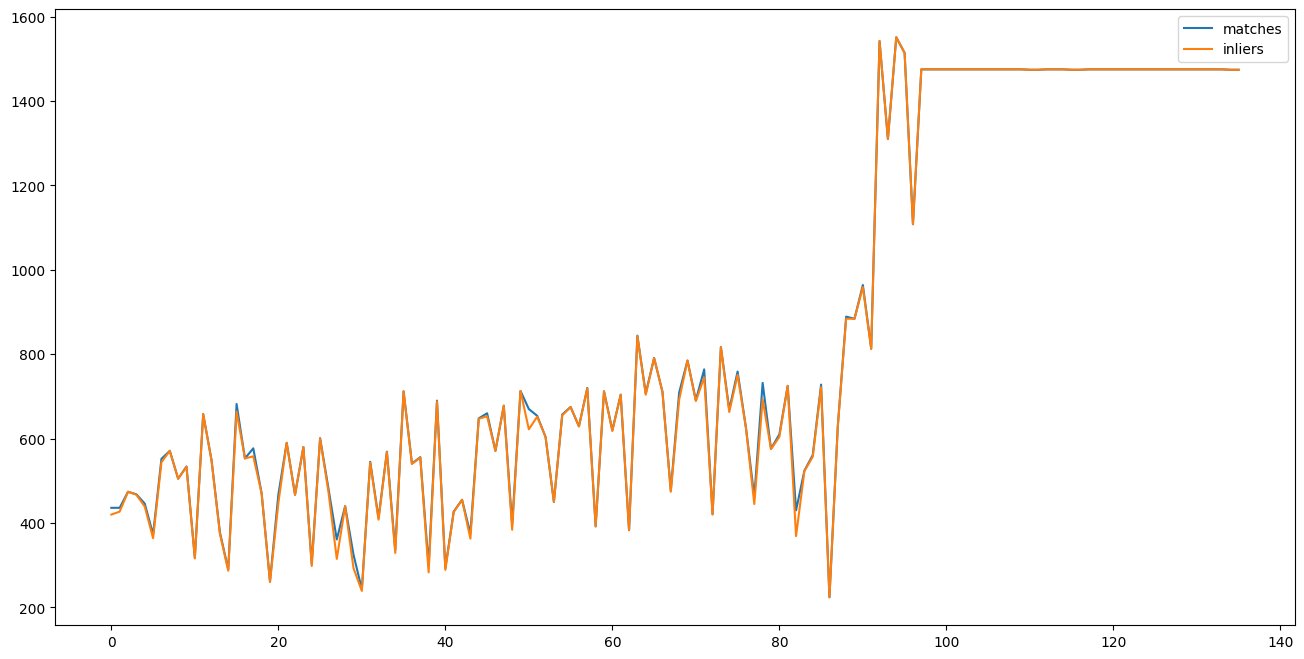

In [141]:
# Frame #027 and #030 due to bed shifting. #86 is when object becomes detached.

df = do_homography_on_folder('FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220503163150')

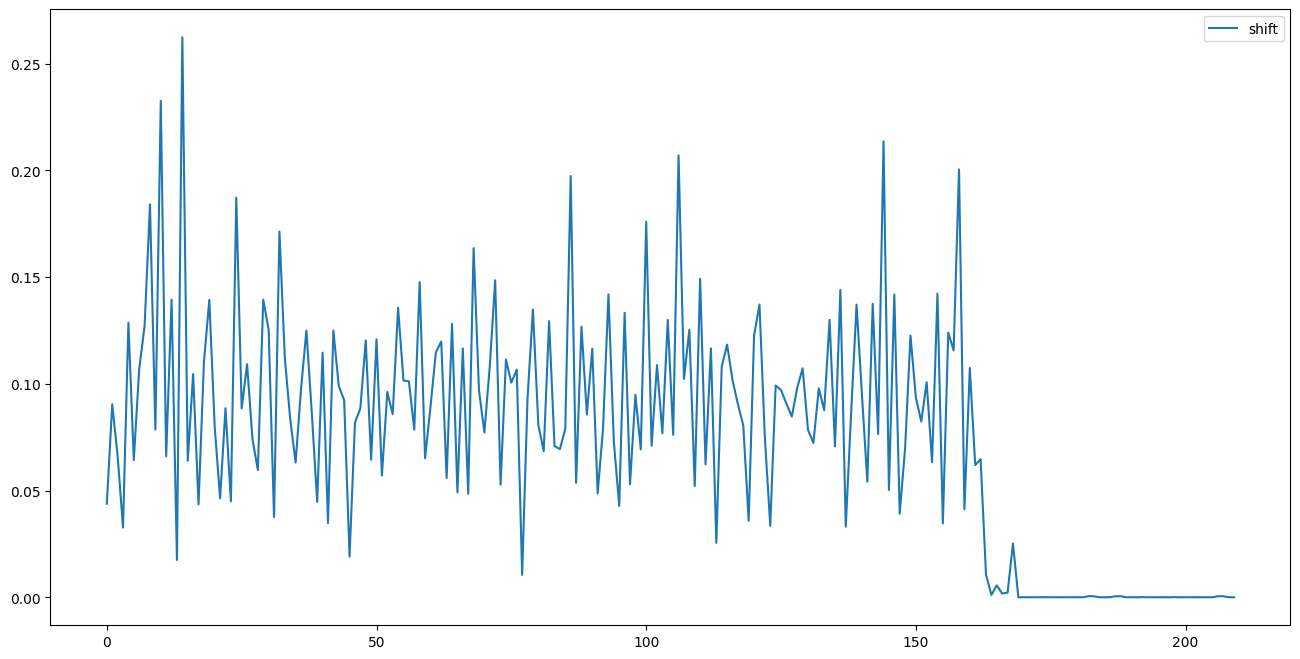

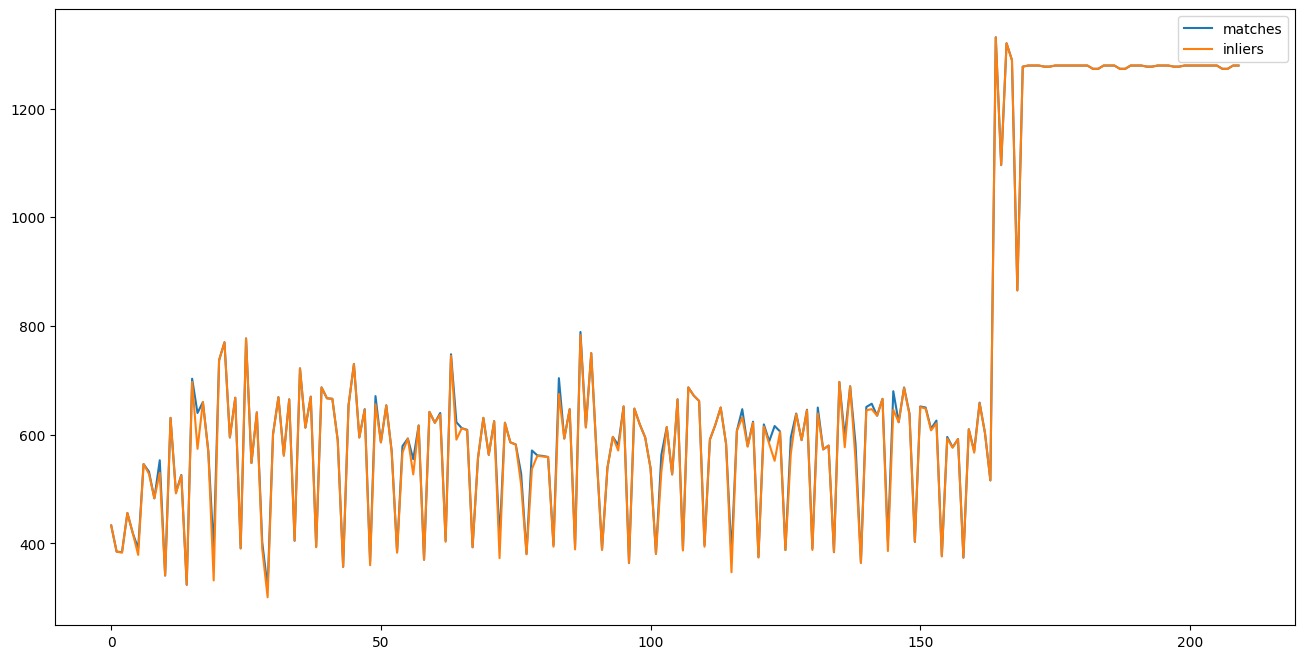

In [142]:
# Frame #017 - filament runs out. But no obvious change until gantry stopped moving, which probably means gantry moving is a major noise driver

df = do_homography_on_folder('FAILED_UMesh_BAO_dumpling_god_v5_0.1mm_PLA_MK3SMMU2S_5h4m_20220910160913')

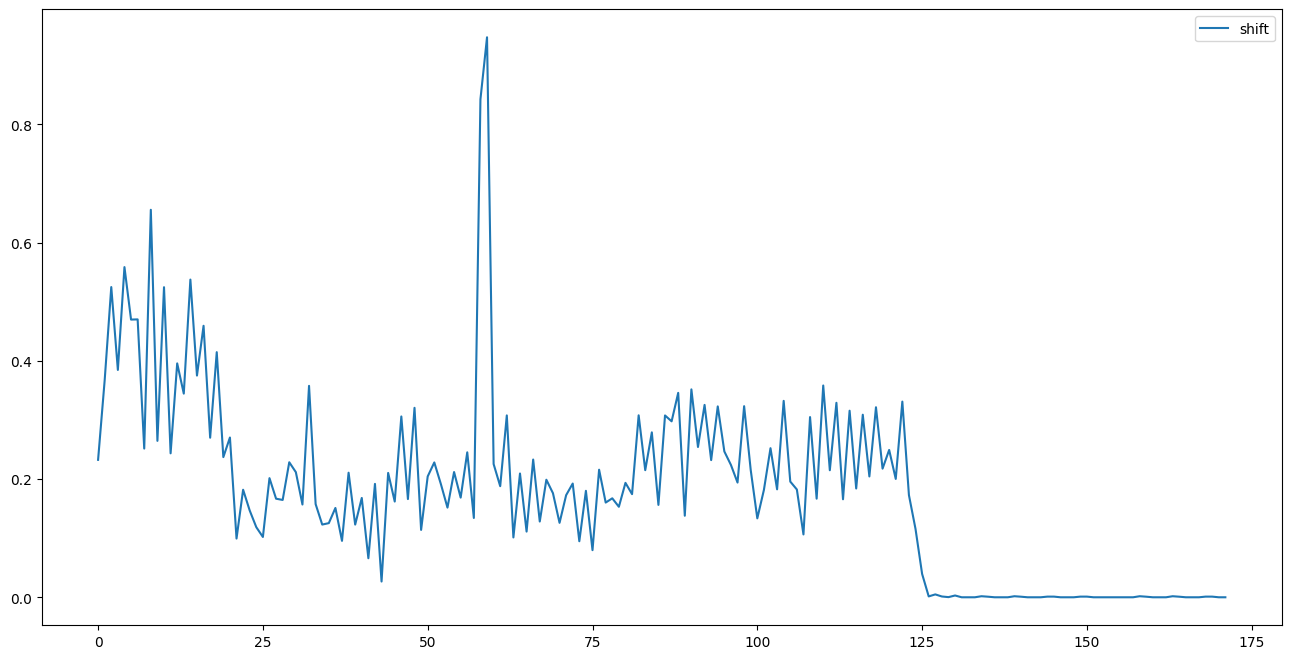

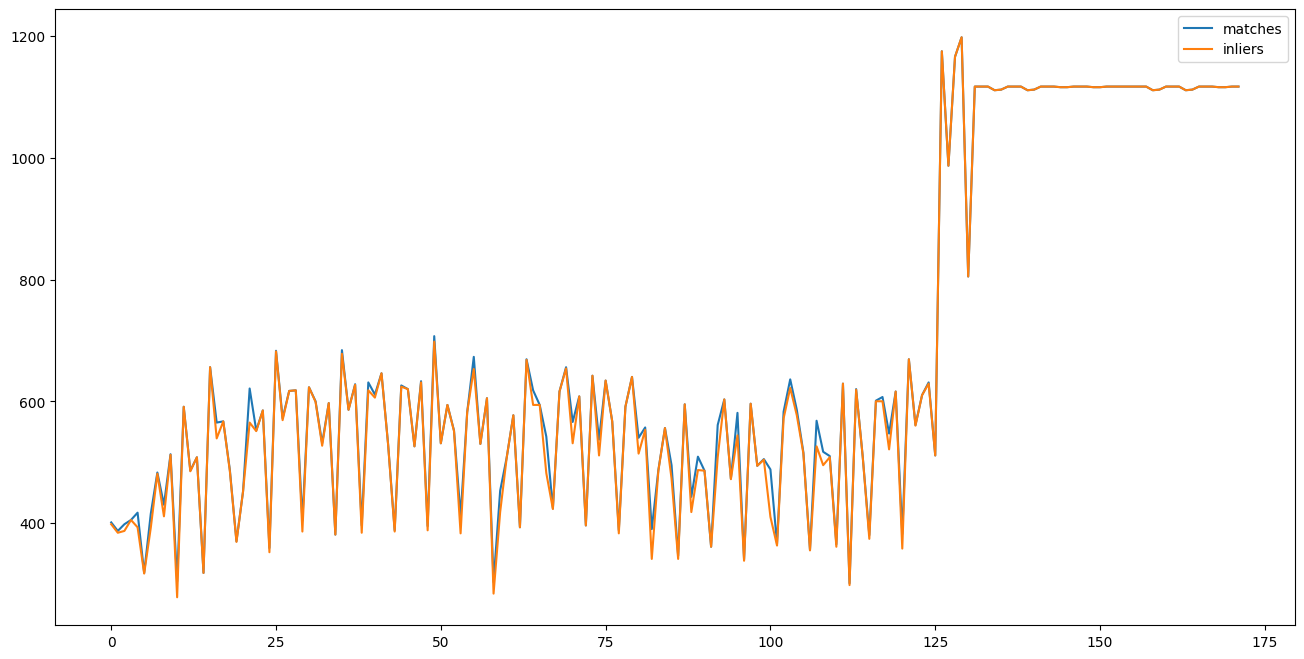

In [143]:
# Before frame #017 - larger areas are being printed hence ssim is lower. Not sure why ssim went lower after #080.
# Frame #112 - light was turned on

df = do_homography_on_folder('FR_Mount_0.2mm_PLA_MK3SMMU2S_6h28m_20220830012149')

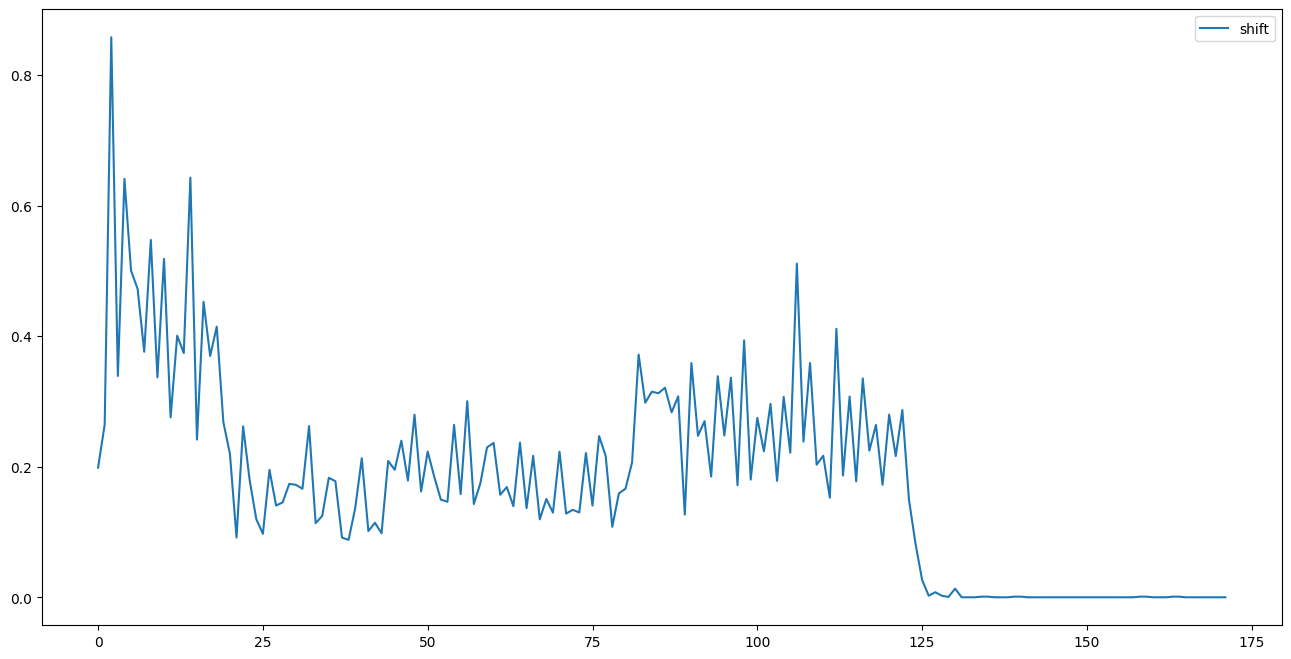

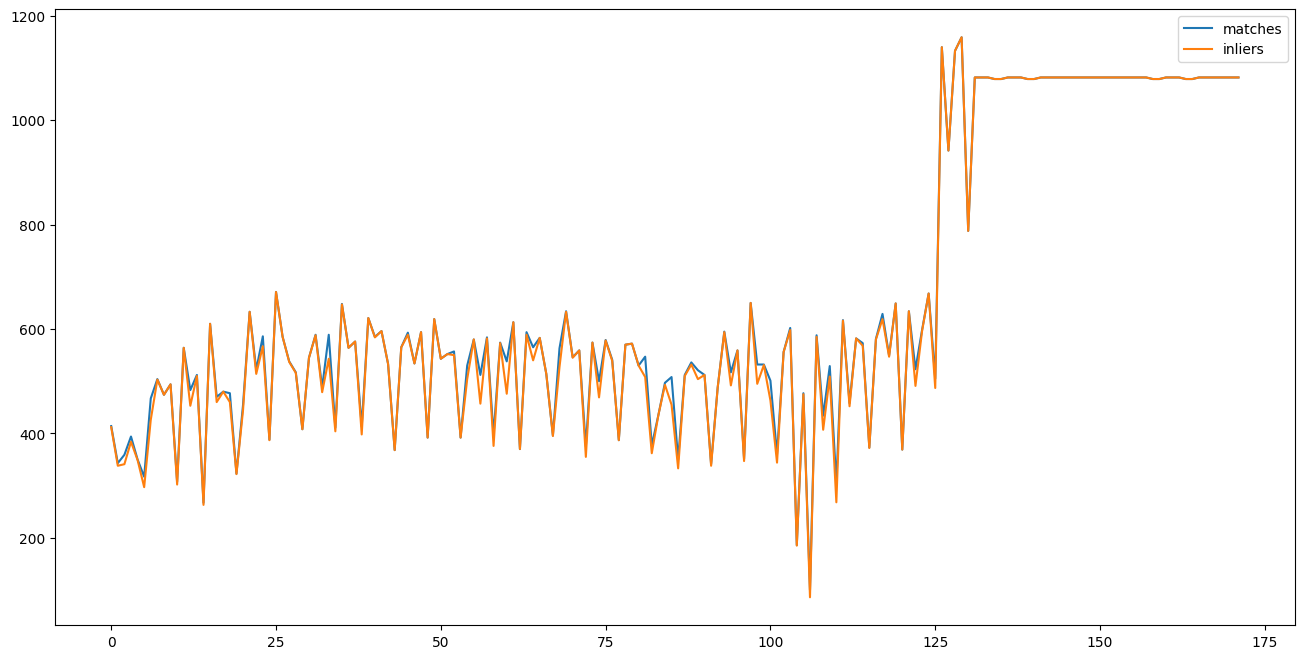

In [144]:
# Frame #104 - light was turned on. Note how similar the chart is to the previous one, which was the same model but different print.

df = do_homography_on_folder('FR_Mount_0.2mm_PLA_MK3SMMU2S_6h28m_20220831202709')

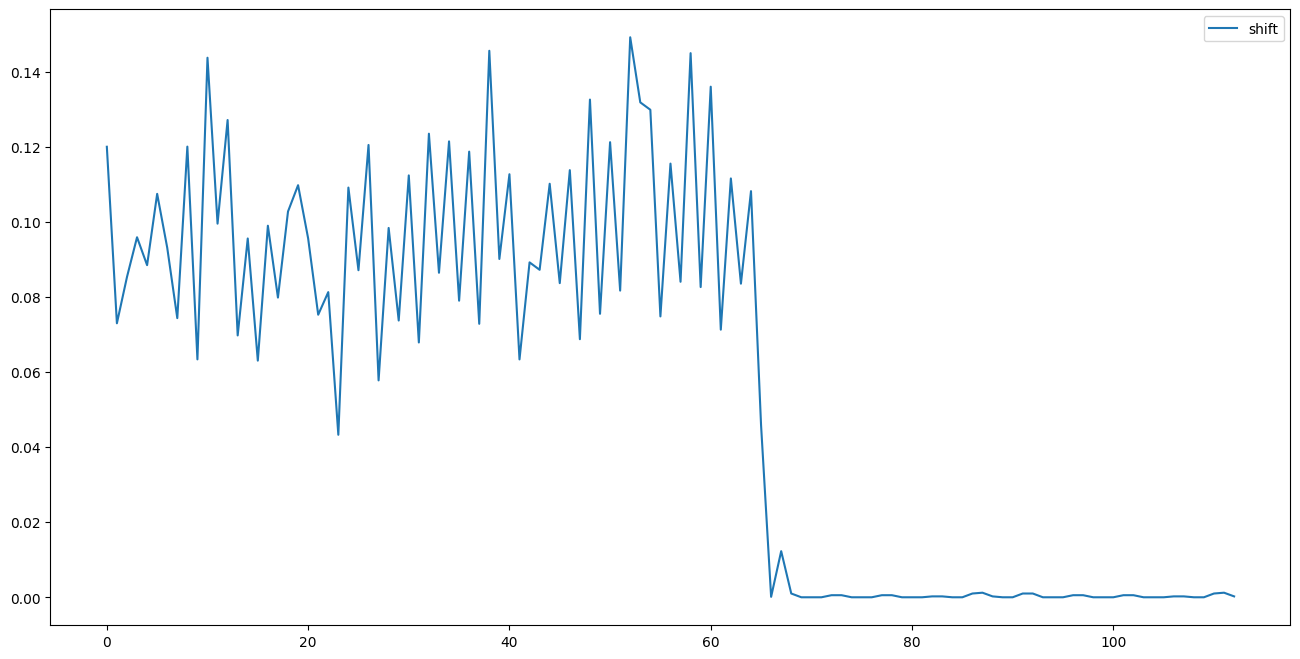

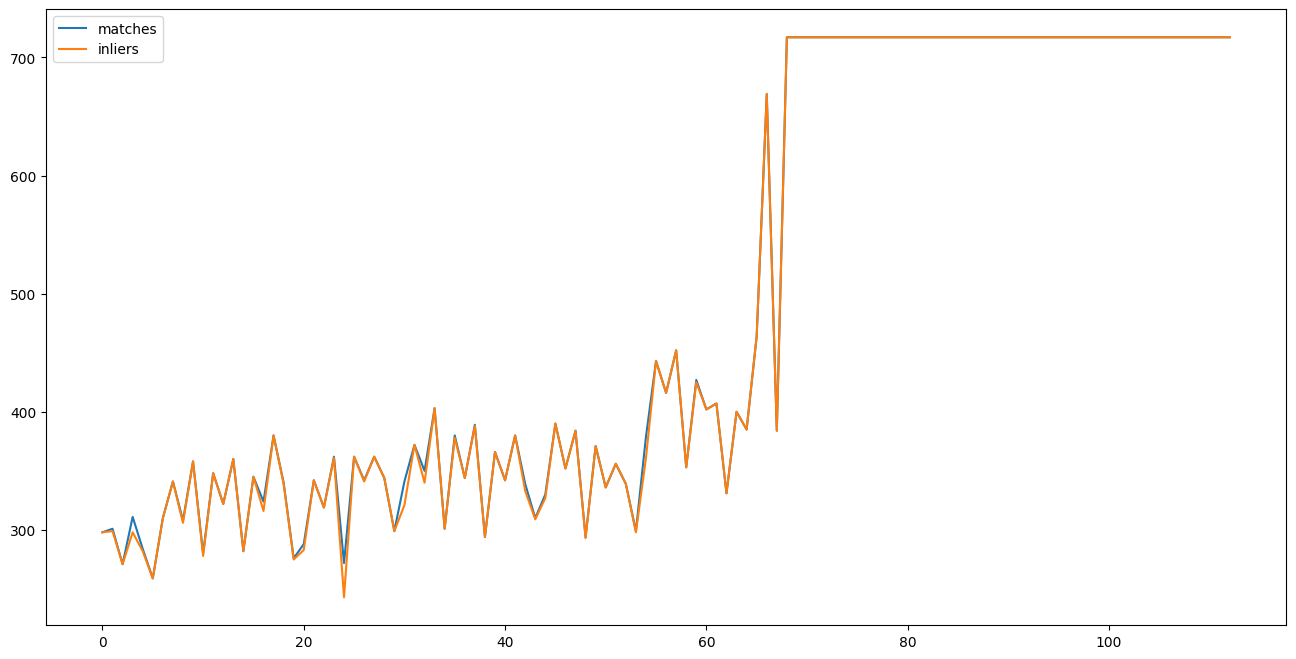

In [145]:
# Frame #053 - slight lighting change for unknown reason.

df = do_homography_on_folder('Merged_0.15mm_PLA_MK3SMMU2S_1h8m_20220324025925')

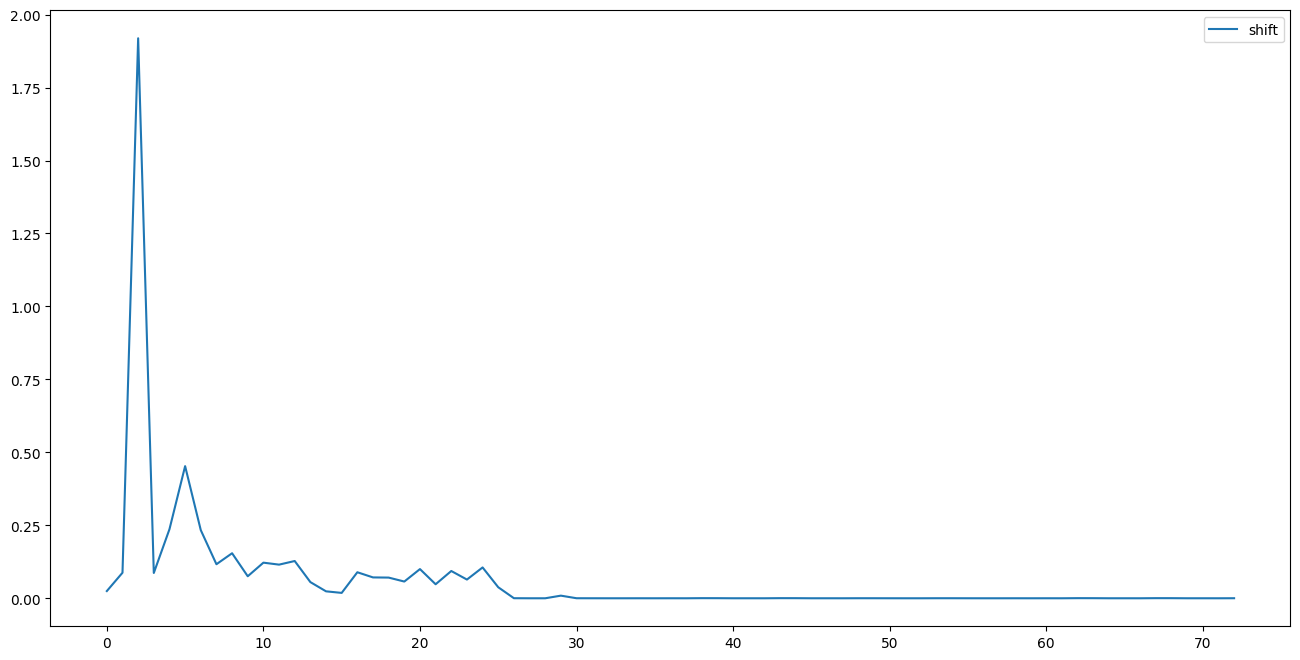

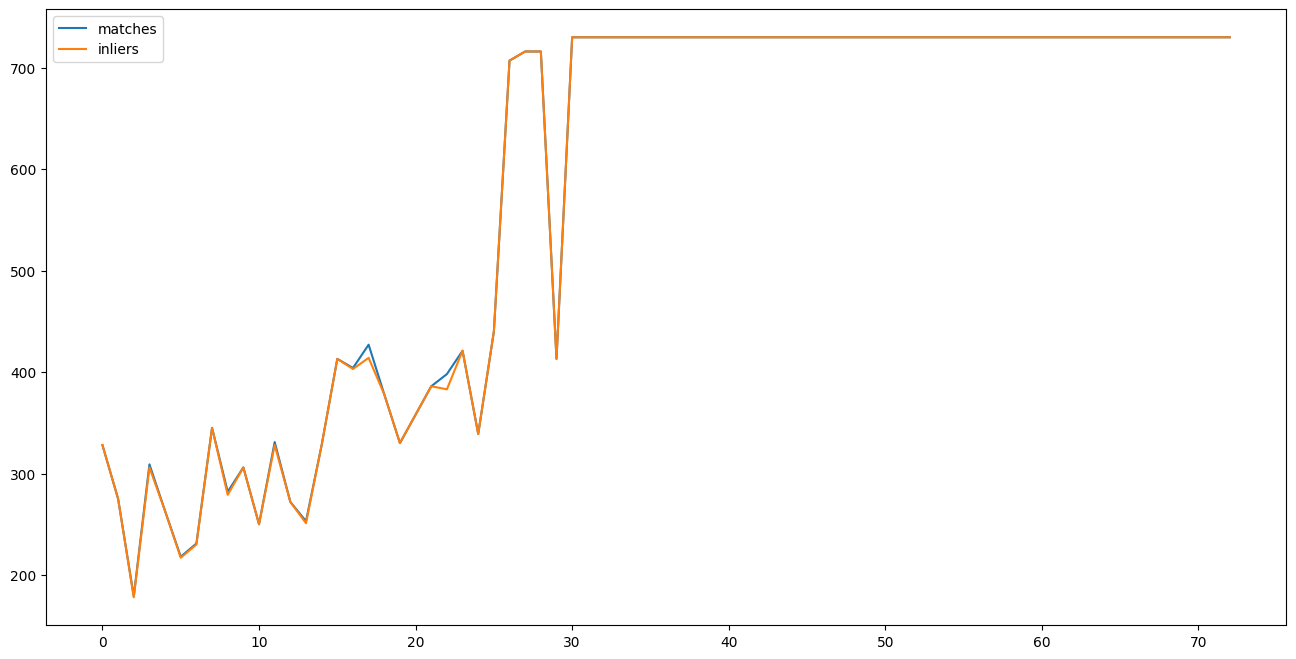

In [146]:
# Frame #002 bed shifting caused much bigger change than seen in #000 and #001

df = do_homography_on_folder('multi_material_test_2_0.15mm_PLA_MK3SMMU2S_5h16m_20220322043743')

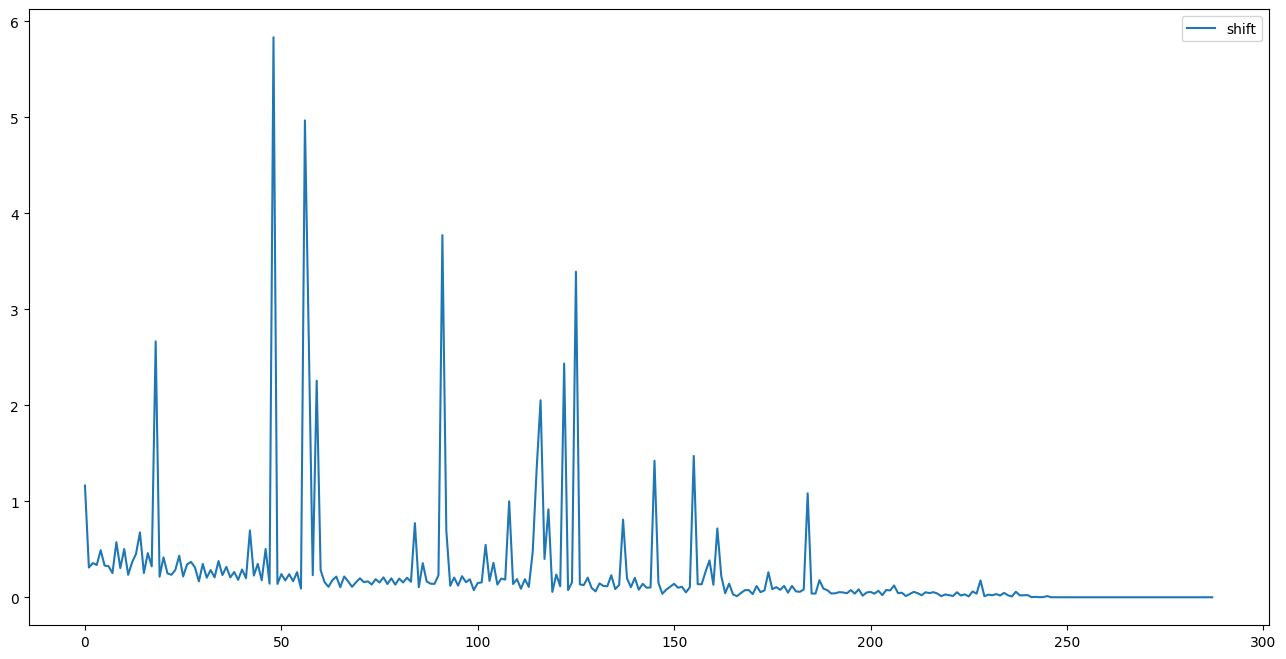

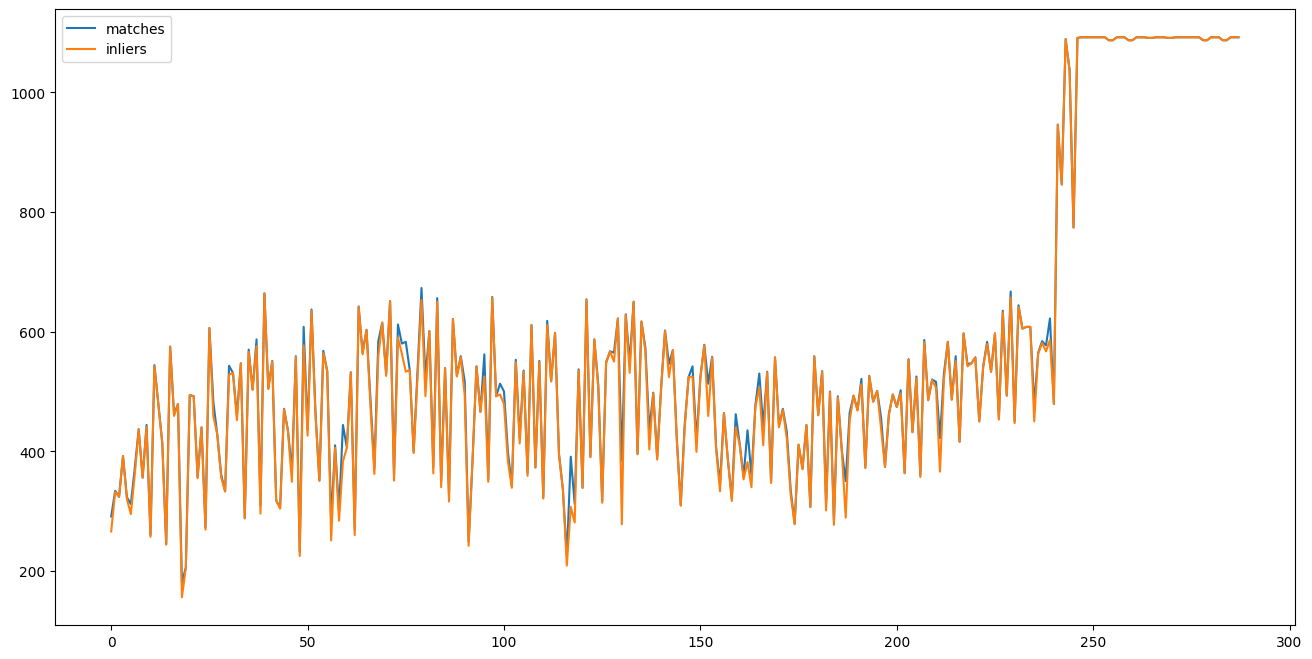

In [147]:
# Frame #018, #048, #056, #091, #122 bed shifted. 

df = do_homography_on_folder('newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220509072520')

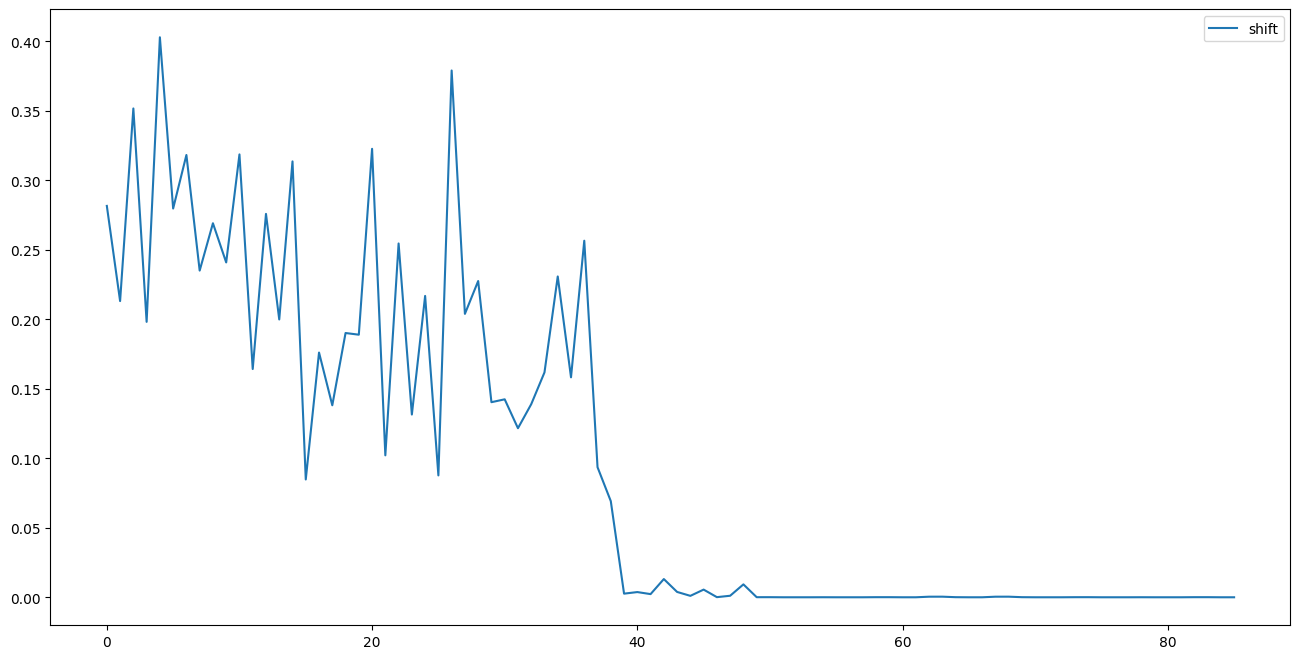

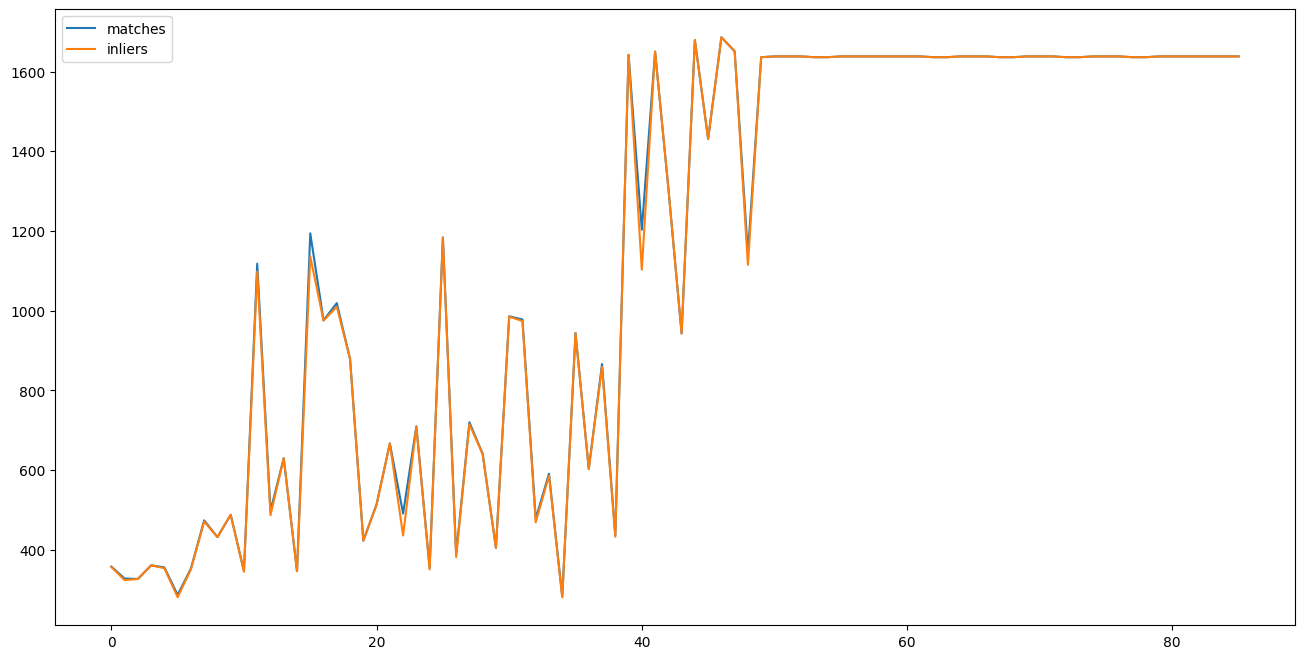

In [148]:
# frame #032 - #035 Some lights were turned on/off

df = do_homography_on_folder('Pixel_6_Pro_Case_with_kickstand_0.2mm_PLA_MK3SMMU2S_2h4m_20220629161032')

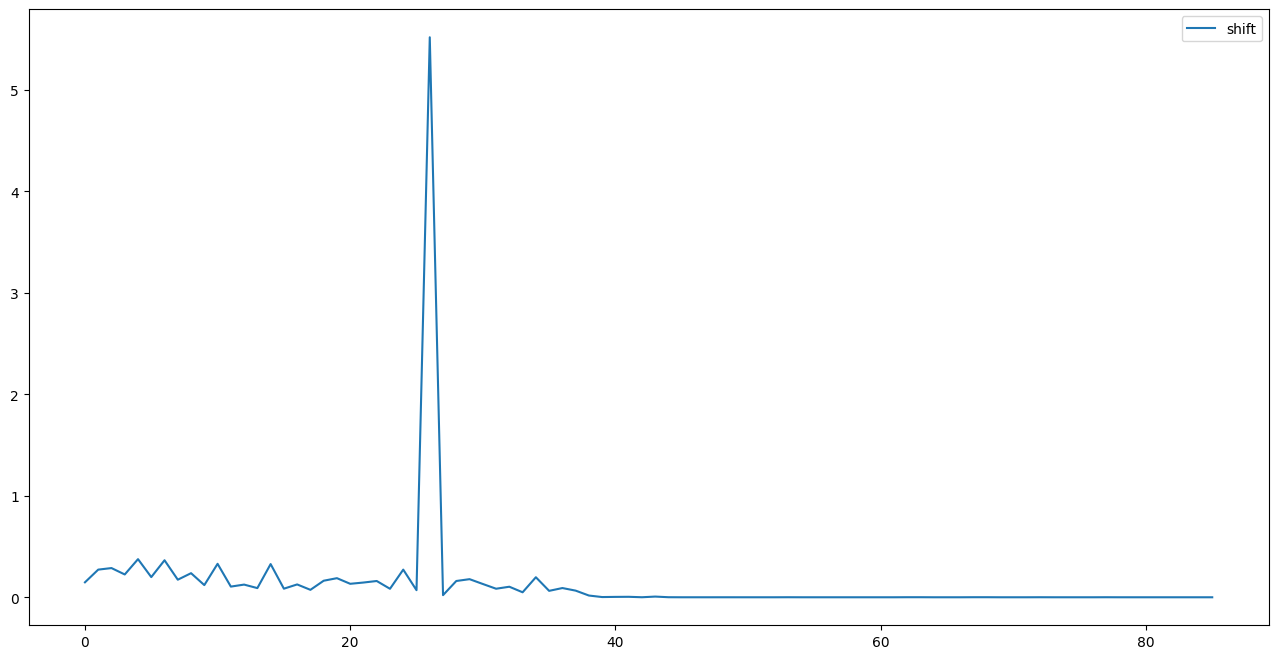

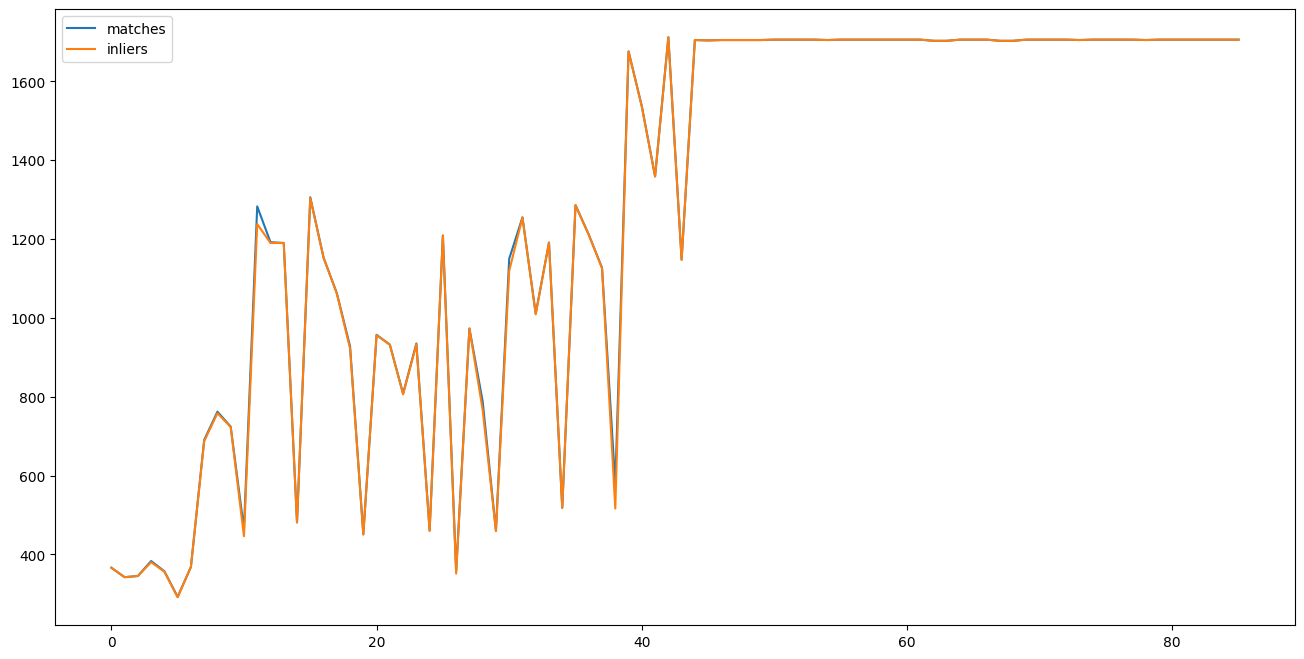

In [149]:
# Before frame #026 - bed shifted

df = do_homography_on_folder('Pixel_6_Pro_Case_with_kickstand_0.2mm_PLA_MK3SMMU2S_2h6m_20220629185935')

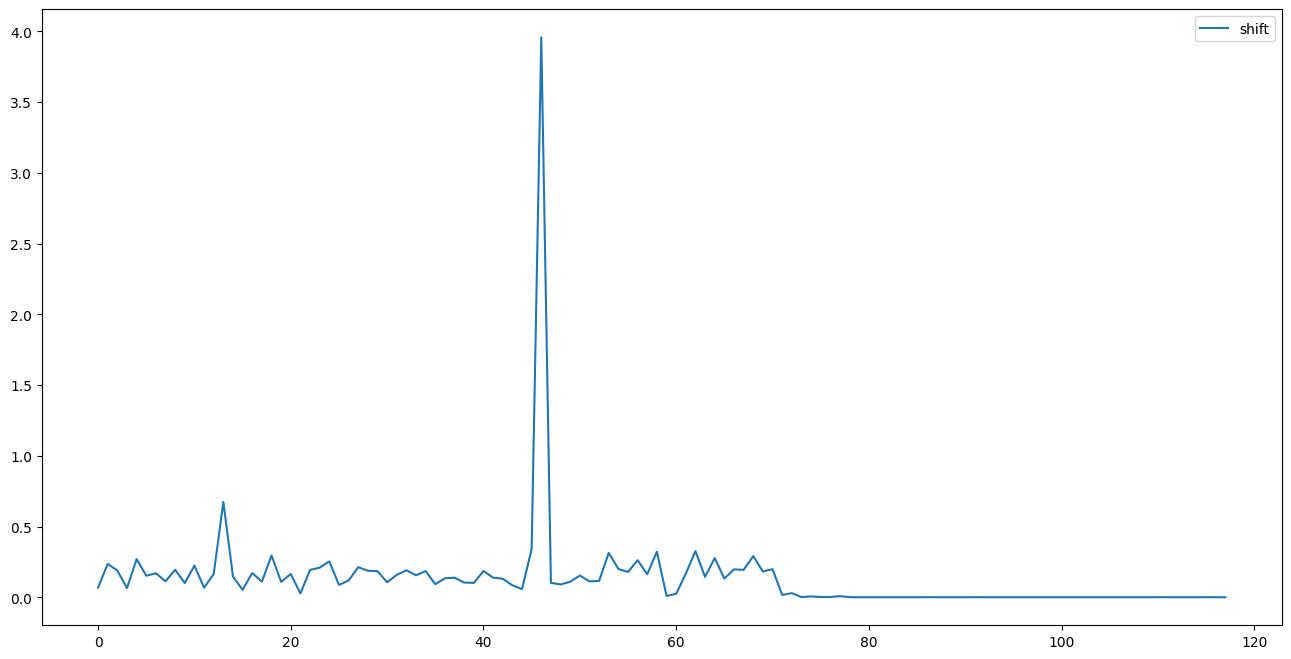

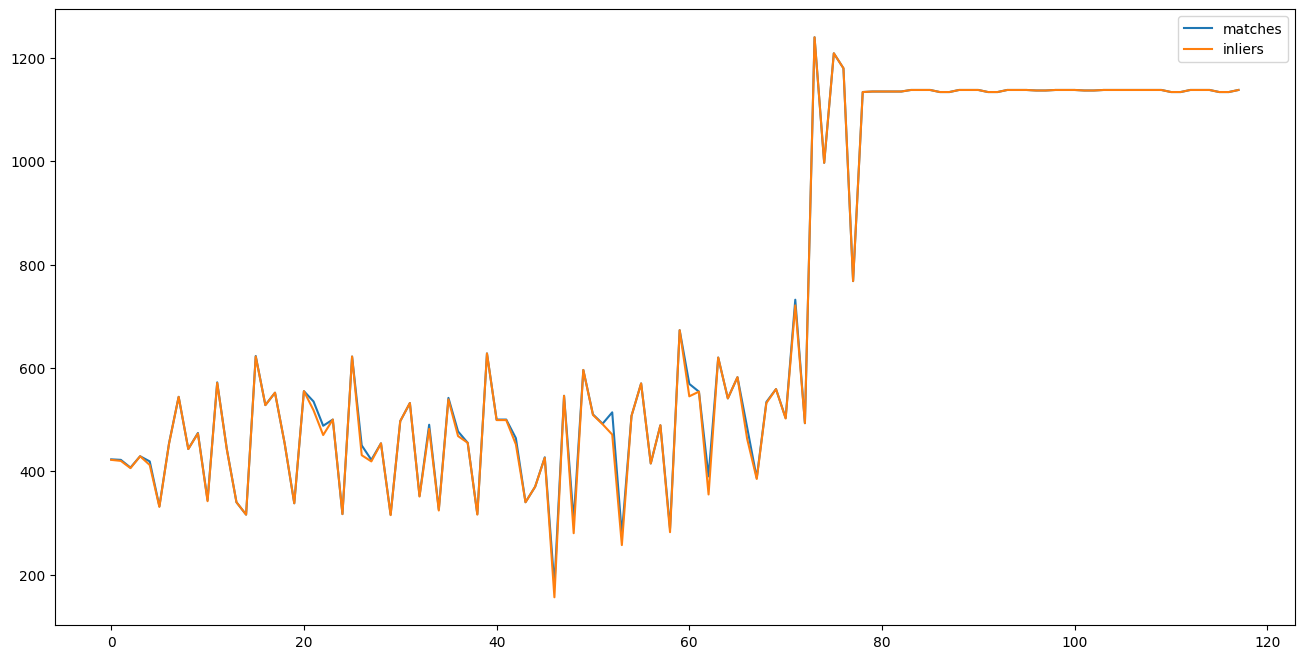

In [150]:
# Before frame #046 - bed shifted

df = do_homography_on_folder('Spotify_0.1mm_PLA_MK3SMMU2S_3h20m_20220825055943')

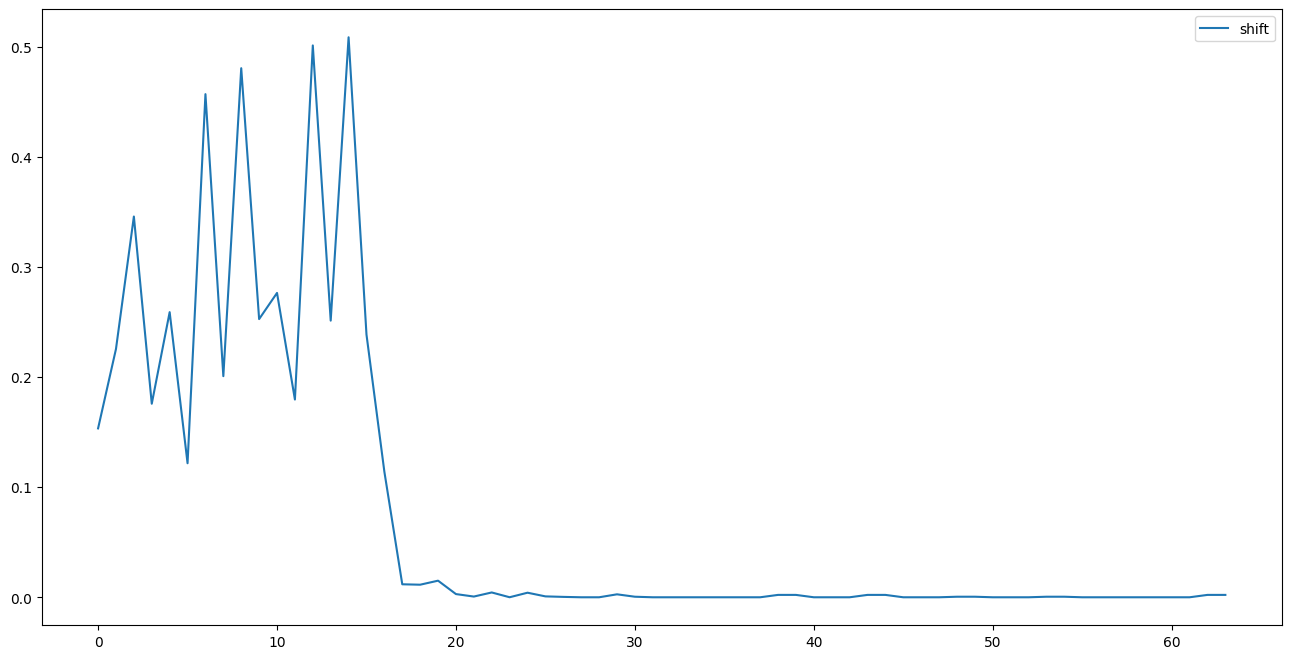

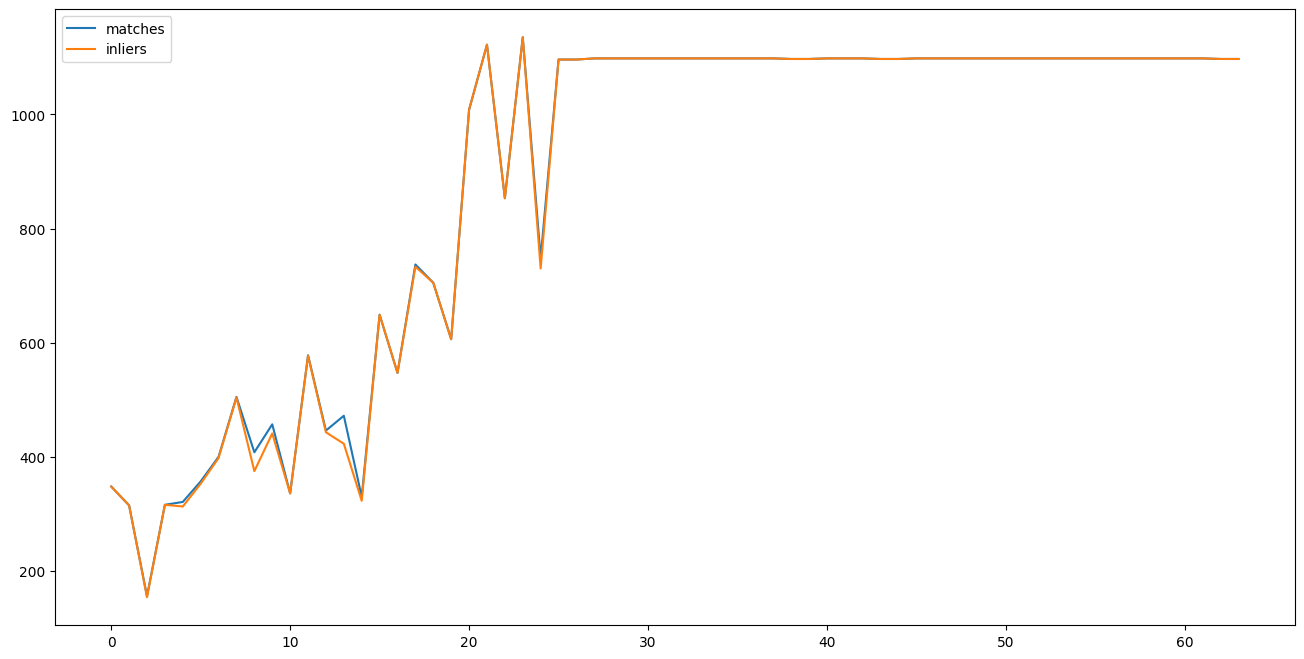

In [151]:
# Before frame #002: light turned off costed much larger change than seen in #001 and #000

df = do_homography_on_folder('Spotify_Logo_0.2mm_PLA_MK3SMMU2S_1h9m_20220823221718')

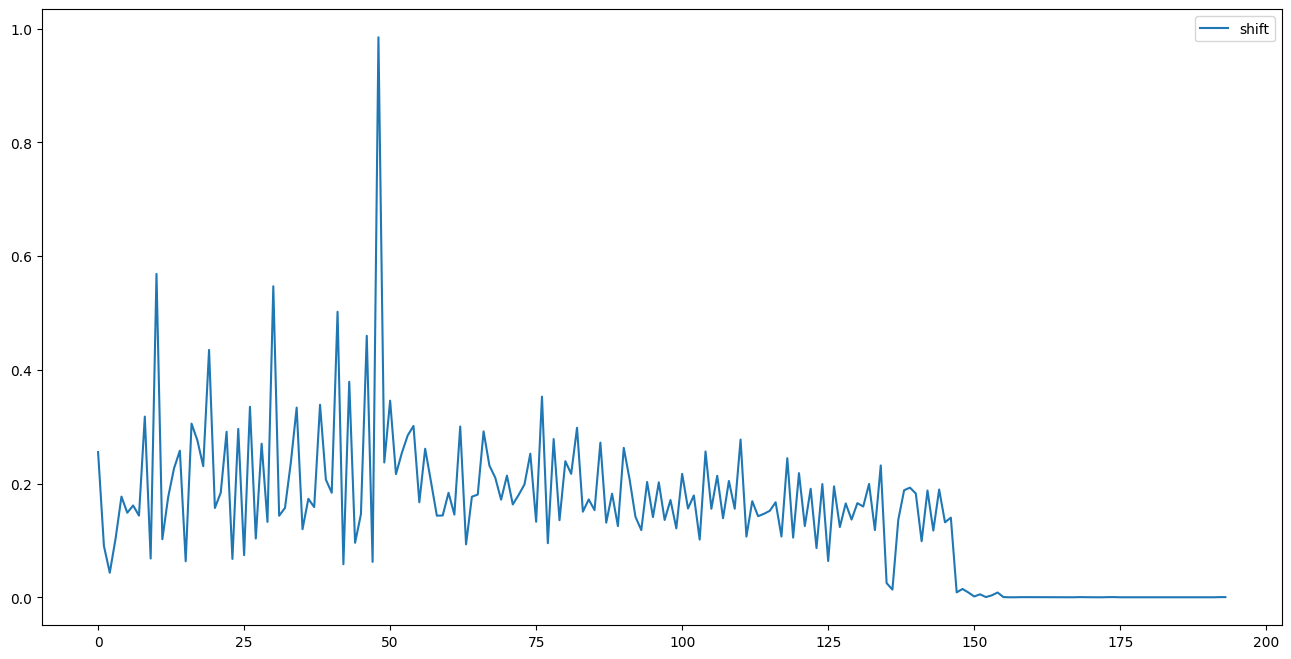

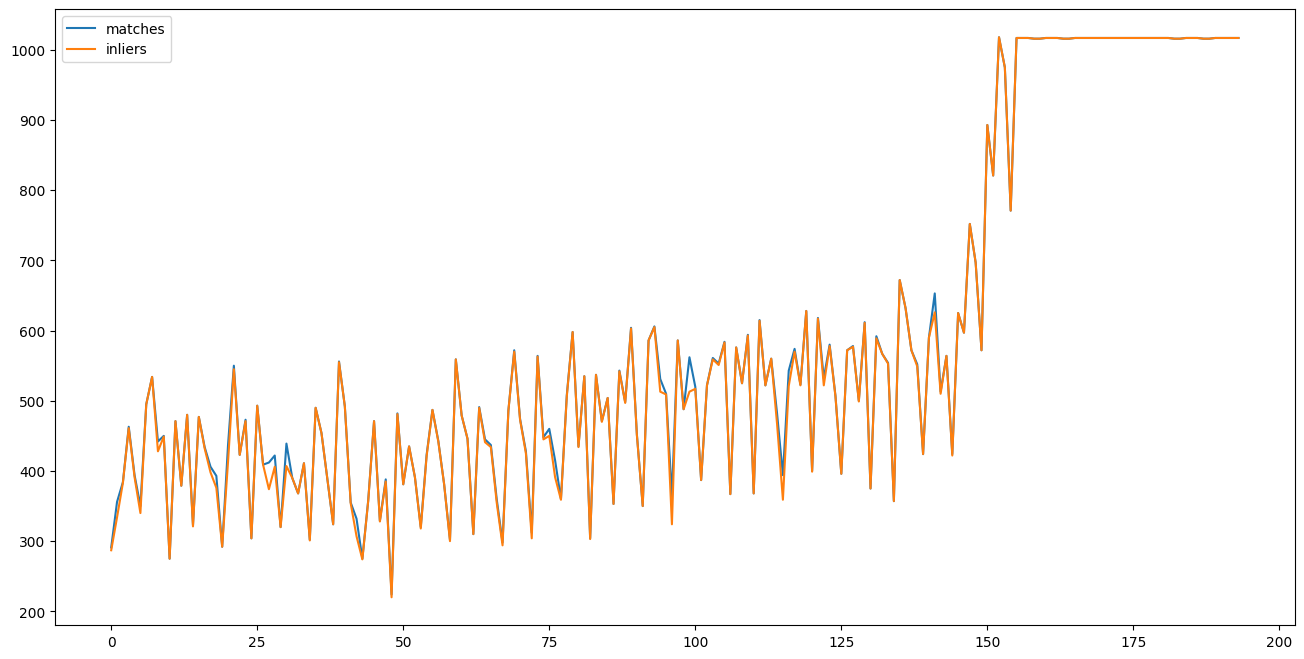

In [152]:
# Frame #048: filament color change.

df = do_homography_on_folder('UMesh_PM3D_Sphere3D6_0.1mm_PLA_MK3SMMU2S_12h23m_20220910101333')

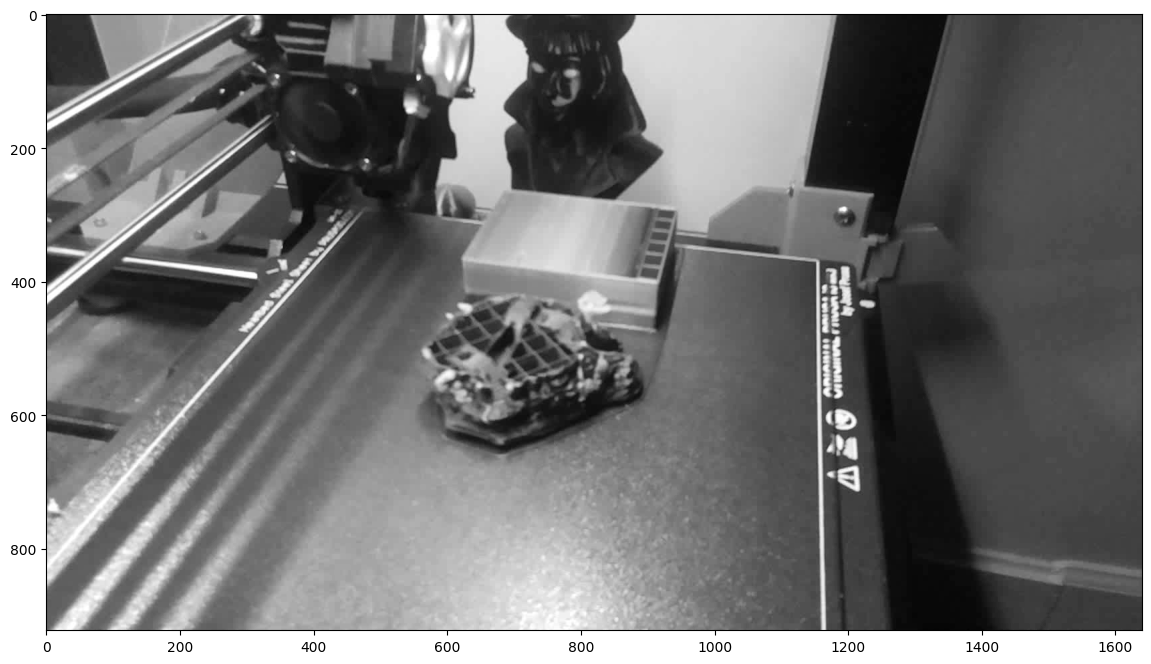

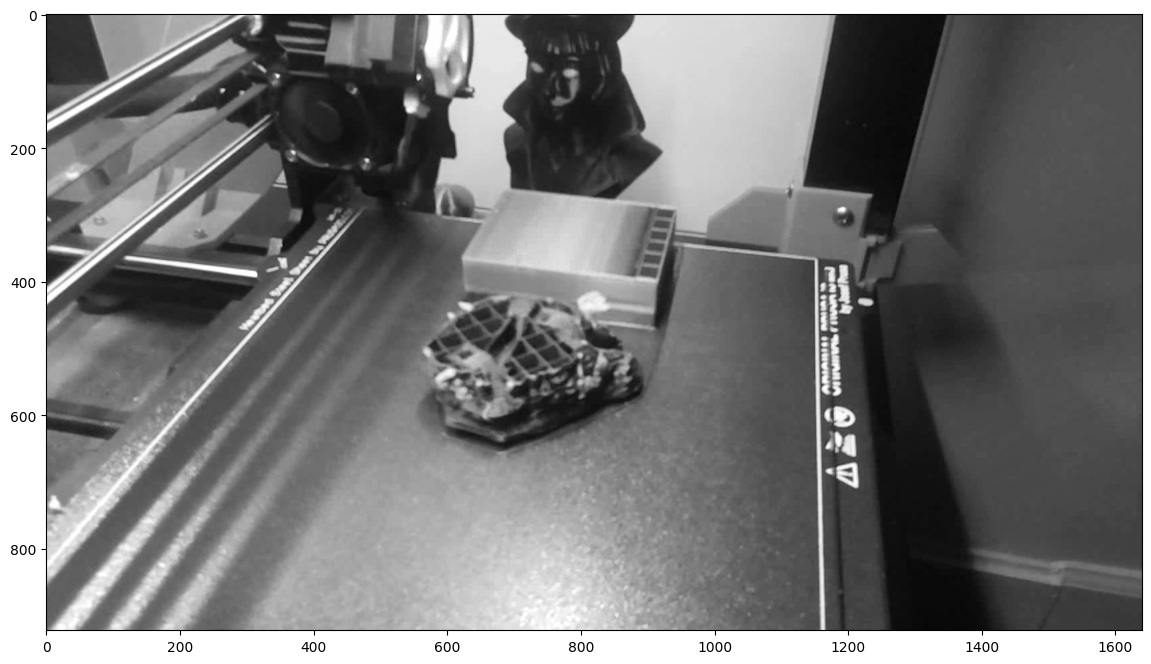

(<matplotlib.image.AxesImage at 0x1348db460>, None)

In [96]:
# frame000043 -> frame000044: Frame shift!!!!

import matplotlib.pyplot as plt

img1 = cv.imread('./jpgs/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220502124240/frame000044.jpg',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('./jpgs/FAILED_newcastlegate06_multi_test01_0.2mm_PLA_MK3SMMU2S_1d20h42m_20220502124240/frame000043.jpg',cv.IMREAD_GRAYSCALE) # trainImage

plt.imshow(img1, 'gray'),plt.show()
plt.imshow(img2, 'gray'),plt.show()

In [97]:
# SIFT feature extraction, then do Flann KNN match.
# Keep match[0].distance < 0.25*match[1].distance

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

MIN_MATCH_COUNT = 10

good = []
for m,n in matches:
    if m.distance < 0.25*n.distance:
        good.append(m)

print('Good matches (match[0].distance < 0.25*match[1].distance): ', len(good))

Good matches (match[0].distance < 0.25*match[1].distance):  298


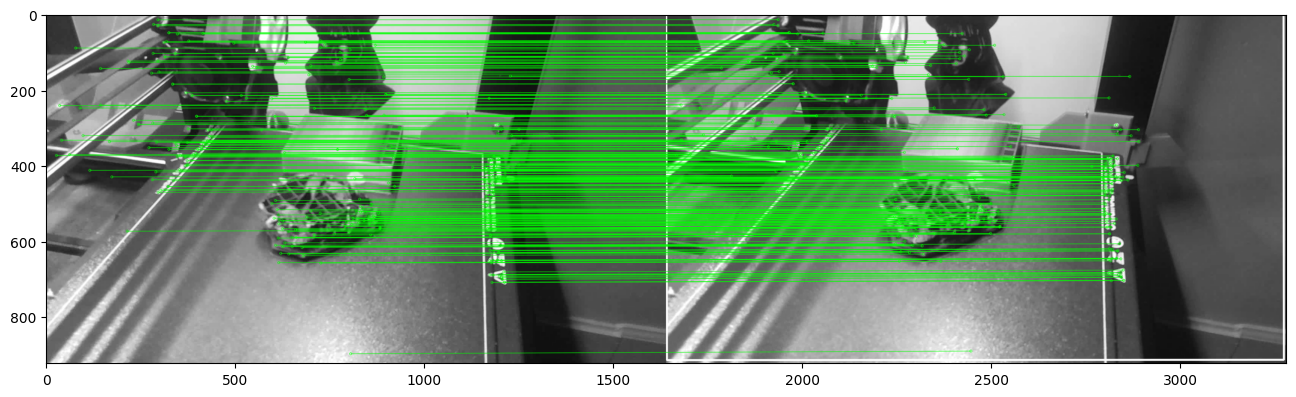

RANSAC inliers:  286
Homography matrix:
[[ 9.99962273e-01  2.17943035e-03  4.59476311e-02]
 [ 1.00809161e-03  9.94109340e-01 -5.89459842e-02]
 [ 1.93840290e-06  8.16761873e-07  1.00000000e+00]]


In [98]:
# Try to find homography matrix with RANSAC mask

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

print('RANSAC inliers: ', np.count_nonzero(mask))
print('Homography matrix:')
print(M)